In [71]:
# packages
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [11]:
plt.rcParams.update({'font.size': 25})
plt.style.use("dark_background")

In [54]:
# read redshift and luminosity distance data from file
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
data = data_scp
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

redshift_scp = data_scp.T[1]
dist_mod_scp = data_scp.T[2] #pc
dist_mod_err_scp = data_scp.T[3] #pc
lum_dist_scp = 10**((dist_mod_scp - 25)/5)
lum_dist_err_scp = lum_dist_scp * np.log(10) * dist_mod_err_scp/5

In [55]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift_snls = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
color_error = data_snls.T[9]
dist_mod_snls = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err_snls = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)

lum_dist_snls = 10**((dist_mod_snls - 25)/5)
lum_dist_err_snls = lum_dist_snls * np.log(10) * dist_mod_err_snls/5

In [56]:
# read redshift and luminosity distance data from file
data_pan = np.genfromtxt('lcparam_full_long_zhel.txt')
redshift_pan = data_pan.T[1] #cmb
dist_mod_pan = data_pan.T[4]+19.5 #pc
dist_mod_err_pan = data_pan.T[5] #pc
lum_dist_pan = 10**((dist_mod_pan - 25)/5)
lum_dist_err_pan = lum_dist_pan * np.log(10) * dist_mod_err_pan/5

In [73]:
data_og = pd.read_csv('hubble_data.csv')
distance_og = data_og.iloc[:, 1]
velocity_og = data_og.iloc[:, 2]
redshift_og = velocity_og/3e5

In [74]:
def D_L(z, omega_m, omega_lambda, H_0):
    omega_k = 1-omega_m-omega_lambda
    if (omega_k == 0): # handle this case separately to avoid division by zero errors
        def integrand(x):
            return 1/np.sqrt((1+x)**2*(1+omega_m*x) - x*(2+x)*omega_lambda)
        integral = integrate.quad(integrand,0,z)[0]
        r = c*integral/H_0
        return (1+z)*r
        
    prefactor = (c/H_0) * (1+z) * (1/np.sqrt(np.abs(omega_k)))
    def integrand(x):
        return 1/np.sqrt((1+x)**2 * (1+omega_m*x) - x * (2+x) * omega_lambda)
    integral = integrate.quad(integrand,0,z)[0]
    arg = np.sqrt(np.abs(omega_k)) * integral
    sinn = np.sin(arg) if omega_k <= 0 else np.sinh(arg)
    return prefactor * sinn

In [75]:
def D_L_helper(redshifts, omega_m, omega_lambda, H_0):
    return [D_L(z,omega_m,omega_lambda,H_0) for z in redshifts]

In [76]:
bnds = ((0,0,60),(2,2,80))
poptscp, pcovscp = opt.curve_fit(D_L_helper, redshift_scp, lum_dist_scp, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_scp)
omega_m_scp, omega_lambda_scp, H_0_scp = poptscp
omega_m_err_scp, omega_lambda_err_scp, H_0_err_scp = np.sqrt(np.diag(pcovscp))

In [77]:
bnds = ((0,0,60),(2,2,80))
poptsnls, pcovsnls = opt.curve_fit(D_L_helper, redshift_snls, lum_dist_snls, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_snls)
omega_m_snls, omega_lambda_snls, H_0_snls = poptsnls
omega_m_err_snls, omega_lambda_err_snls, H_0_err_snls = np.sqrt(np.diag(pcovsnls))

In [78]:
bnds = ((0,0,60),(2,2,80))
poptpan, pcovpan = opt.curve_fit(D_L_helper, redshift_pan, lum_dist_pan, p0=[0.3,0.7,70], bounds = bnds, sigma = lum_dist_err_pan)
omega_m_pan, omega_lambda_pan, H_0_pan = poptpan
omega_m_err_pan, omega_lambda_err_pan, H_0_err_pan = np.sqrt(np.diag(pcovpan))

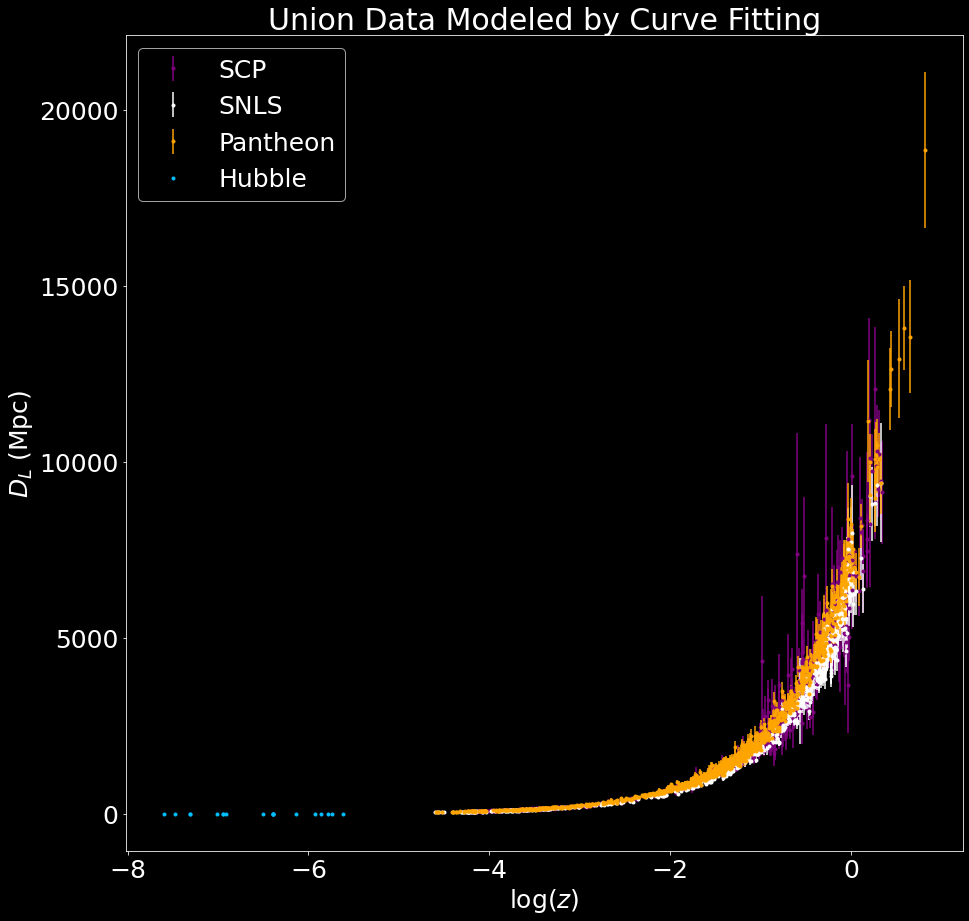

In [83]:
plt.figure(figsize = (15,15))
zz = np.linspace(np.min(redshift_scp),np.max(redshift_scp),1000)
plt.errorbar(np.log(redshift_scp),lum_dist_scp,yerr=lum_dist_err_scp,fmt='.',color='purple', label = 'SCP')
plt.errorbar(np.log(redshift_snls),lum_dist_snls,yerr=lum_dist_err_snls,fmt='.',color='white', label = 'SNLS')
plt.errorbar(np.log(redshift_pan),lum_dist_pan,yerr=lum_dist_err_pan,fmt='.',color='orange', label = 'Pantheon')
plt.errorbar(np.log(redshift_og),distance_og,fmt='.',color='deepskyblue', label = 'Hubble')


plt.xlabel("$\log(z)$")
plt.ylabel("$D_L$ (Mpc)")
plt.legend(loc='upper left')
plt.title("Union Data Modeled by Curve Fitting");

# SCP (Perlmutter Group) Dataset Phase Space

In [12]:
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
#nothing

In [49]:
# read redshift and luminosity distance data from file
data_scp = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
data = data_scp
with open('SCPUnion2.1_mu_vs_z.txt') as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)

redshift_scp = data_scp.T[1]
dist_mod_scp = data_scp.T[2] #pc
dist_mod_err_scp = data_scp.T[3] #pc
lum_dist_scp = 10**((dist_mod_scp - 25)/5)
lum_dist_err_scp = lum_dist_scp * np.log(10) * dist_mod_err_scp/5

In [14]:
def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms

Matter Density is: 0.15254237288135594
Dark Energy Density is: 0.4044943820224719


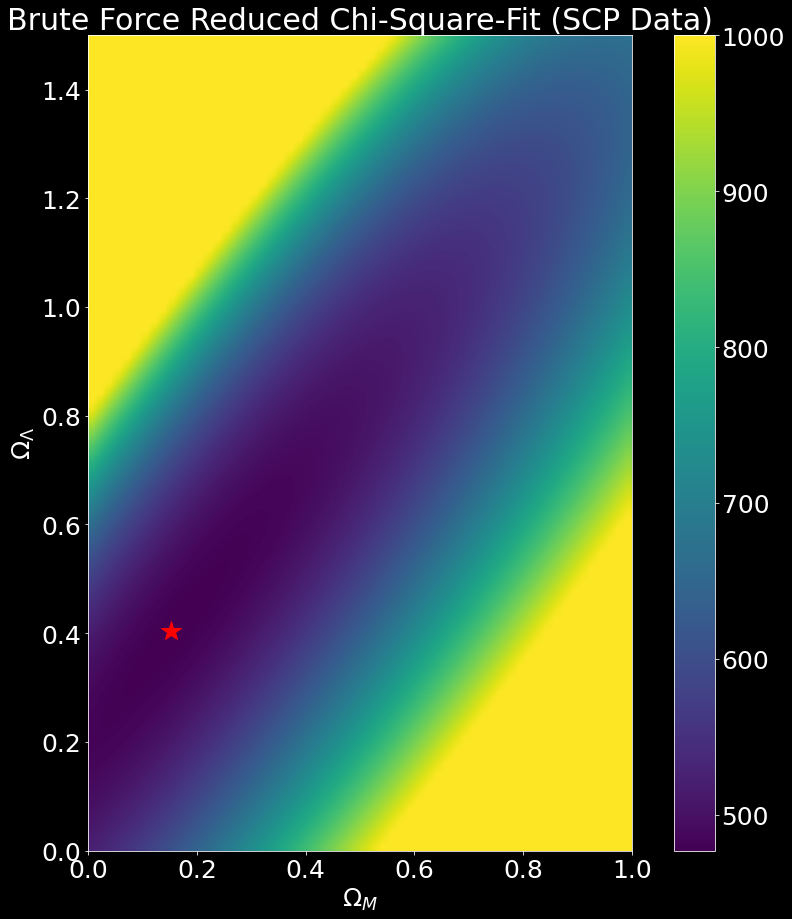

In [15]:

Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SCP Data)')
plt.show()

In [17]:
from astropy.cosmology import FlatLambdaCDM as magic

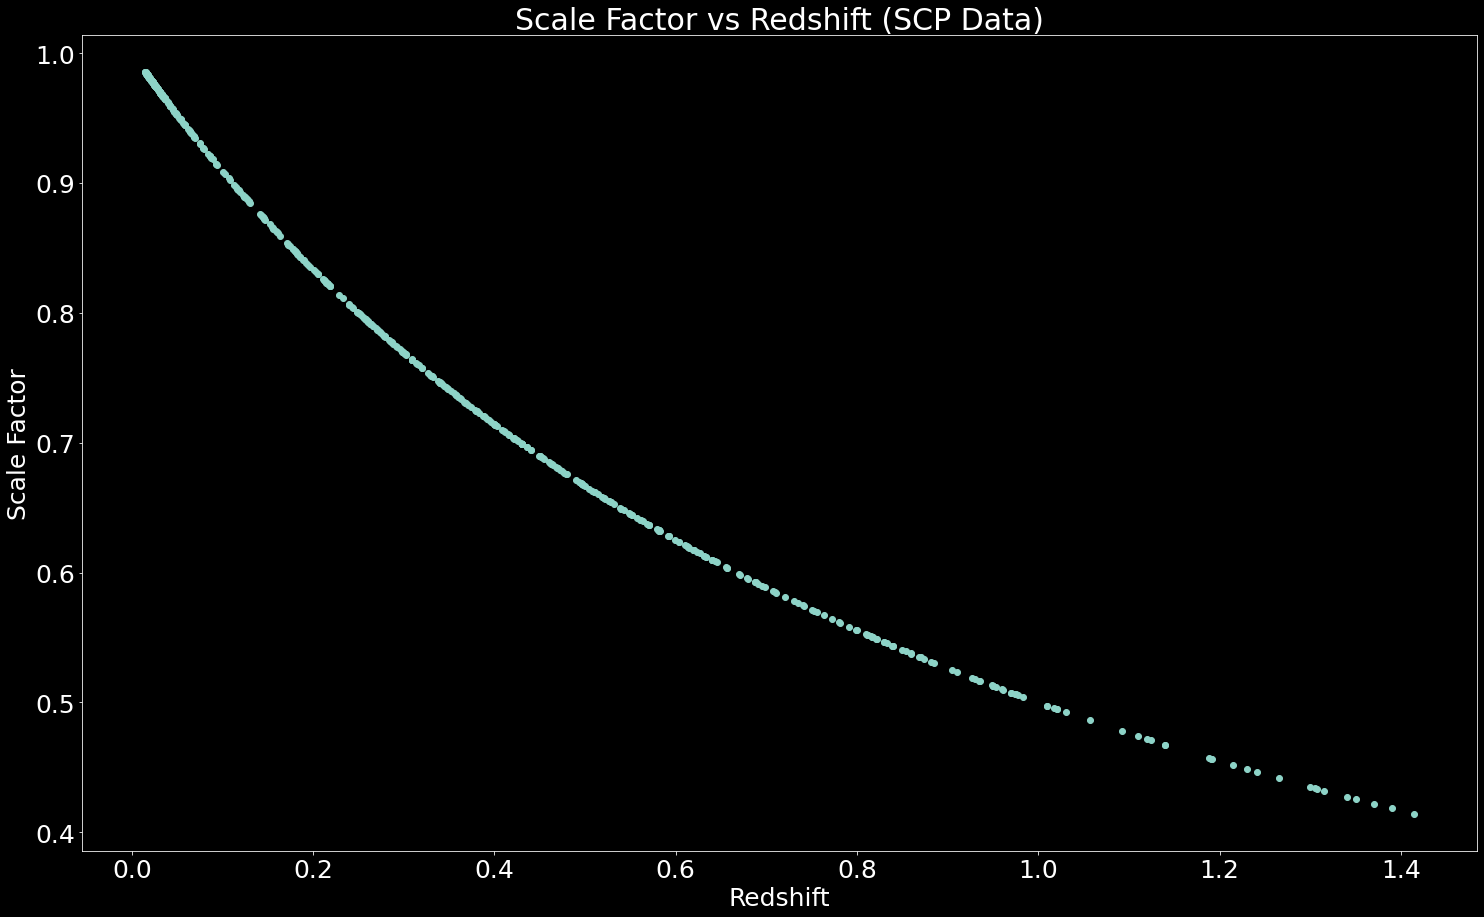

In [42]:
cosmo = magic(H0=H0, Om0=X[am])
plt.figure(figsize = (25,15))
scale_factor = cosmo.scale_factor(redshift)
plt.scatter(redshift, scale_factor)
plt.xlabel('Redshift')
plt.ylabel('Scale Factor')
plt.title('Scale Factor vs Redshift (SCP Data)')
plt.show()

In [22]:
cosmo.age(redshift)

<Quantity [16.09205318, 15.79822327, 15.75949743, 15.53173503, 15.62962166,
           15.3041535 , 15.42074268, 16.24863175, 15.90380627, 15.86229318,
           15.98221762, 16.21547192, 15.1340063 , 16.10789011, 15.47252466,
           16.11969226, 15.79985152, 16.06286921, 16.26097731, 16.27372872,
           16.06390233, 16.14691274, 16.1548527 , 16.12593726, 15.81296692,
           16.149841  , 16.27752179, 15.99261687, 15.8147186 , 16.18228227,
           14.84053369, 15.98878446, 16.26132266, 16.25559181, 16.10570535,
           16.18488553, 16.25951482, 16.16520235, 15.98253219, 16.22014931,
           16.24334101, 16.05014878, 16.16064457, 16.2554097 , 15.74898947,
           16.2519362 , 16.10065988, 16.24938777, 16.0718123 , 16.25798749,
           16.27985185, 15.73974954, 14.45687389, 15.94371411, 14.84423214,
           14.60046012, 14.77295637, 15.423045  , 15.68766695, 16.05879271,
           15.92600828, 16.2770446 , 16.17643779, 16.26582246, 15.98604781,
           1

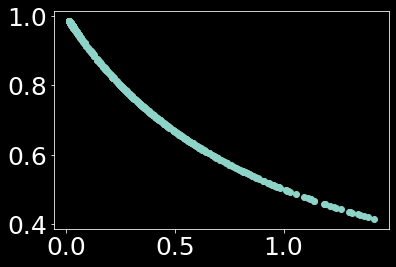

In [33]:
scale_factor = cosmo.scale_factor(redshift)
plt.scatter(redshift, scale_factor)

In [32]:
np.shape(scale_factor)

(580,)

In [25]:
cosmo.w(redshift)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

# SNLS Data

70
Matter Density is: 0.13559322033898305
Dark Energy Density is: 0.5561797752808989


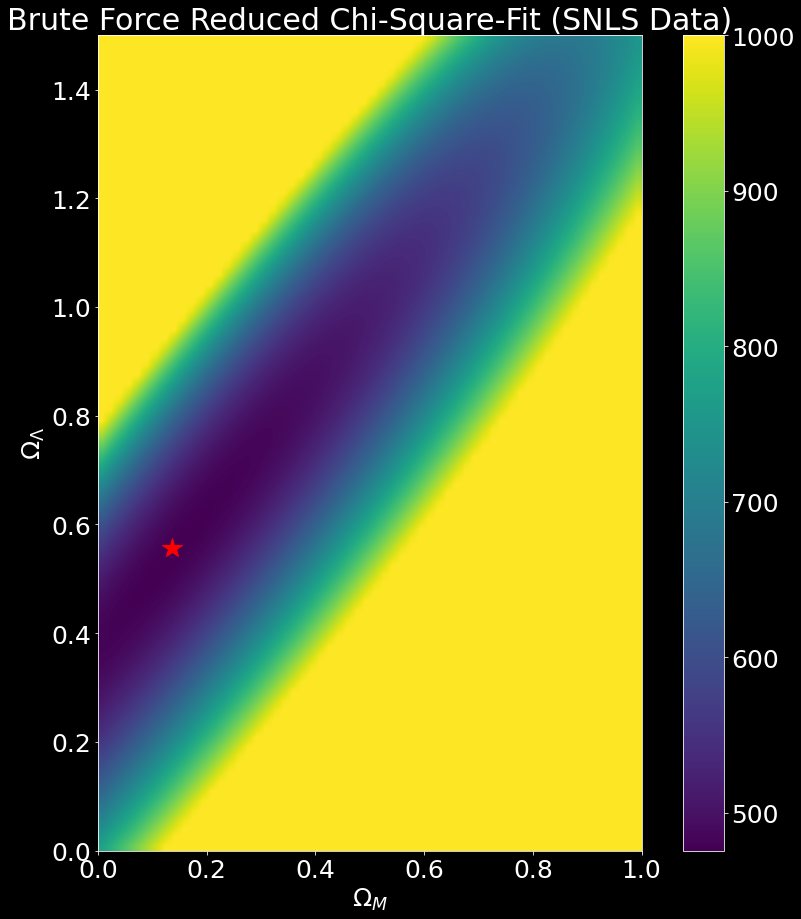

In [46]:
data_snls = np.genfromtxt('snls_3rdyear_lcparams.txt')
redshift = data_snls.T[1]  # CMB-frame redshift
alpha = 1.4 # fit params
beta = 3.2 # fit params
b_band_lum = data_snls.T[4]
color_measure = data_snls.T[8]
stretch_factor = data_snls.T[6]
stretch_factor_error = data_snls.T[7]
b_band_lum_err = data_snls.T[5]
redshift = data_snls.T[1]
color_error = data_snls.T[9]
dist_mod = b_band_lum + alpha * (stretch_factor - 1) - beta * color_measure + 19
dist_mod_err = np.sqrt(b_band_lum_err**2 + (alpha*stretch_factor_error)**2 + (beta*color_error)**2)


redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = 70
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
print(H0)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms


Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SNLS Data)')

plt.show()

# Pantheon

In [21]:
data_pan = np.genfromtxt('lcparam_full_long_zhel.txt')


0.01012
[22.93445 22.8802  24.0377  ... 24.85445 25.54235 24.63835]
[0.12605 0.11765 0.2056  ... 0.2291  0.1987  0.26405]
Matter Density is: 0.2711864406779661
Dark Energy Density is: 0.6235955056179775


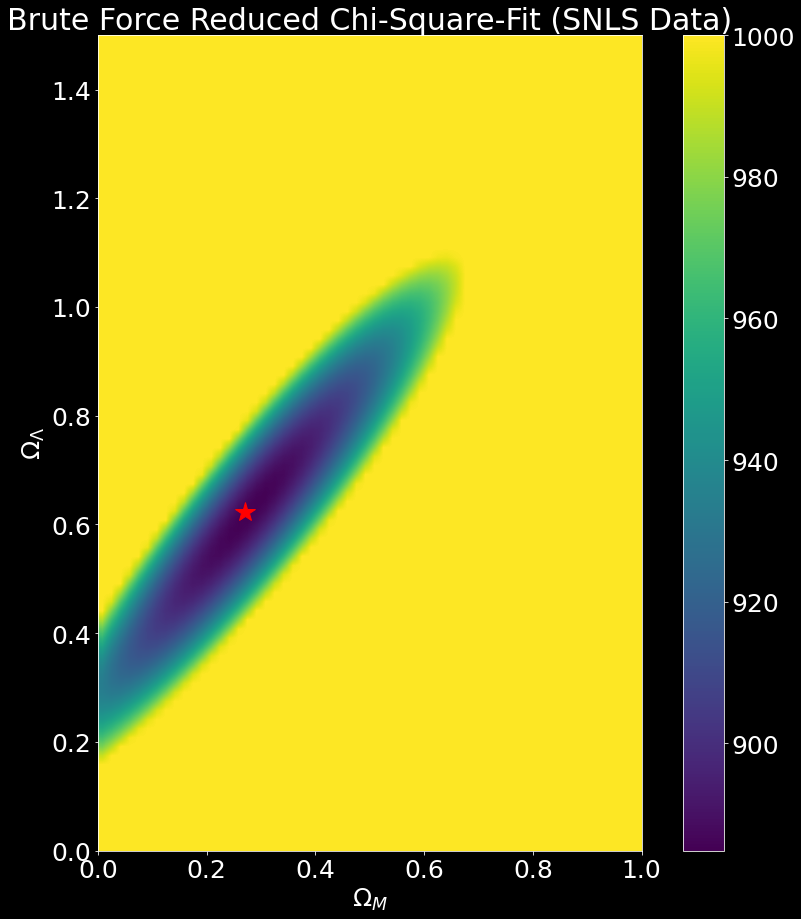

In [49]:
redshift = data_pan.T[1] #cmb
dist_mod = data_pan.T[4] #pc
dist_mod_err = data_pan.T[5] #pc
print(np.min(redshift))
print(dist_mod)
print(dist_mod_err)
redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = 67
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


def redshift_pred(omega_m,omega_L,z):
    omega_k = 1.-omega_m-omega_L
    omega_total = omega_m*(1+redshift_guess)**3+omega_k*(1+redshift_guess)**2+omega_L
    omega_total[omega_total<0.001] = 0.001
    comoving_distance = np.cumsum(1./np.sqrt(omega_total))*redshift_size
    if (omega_k < 0.):
        trans_comoving = np.sin(np.sqrt(-omega_k)*comoving_distance)/np.sqrt(-omega_k)
        trans_comoving[trans_comoving < 0.0001] = 0.0001  
    elif (omega_k > 0.):
        trans_comoving = np.sinh(np.sqrt(omega_k)*comoving_distance)/np.sqrt(omega_k)
    else:
        trans_comoving = comoving_distance
    mc = m0 + 5.0*np.log10(dH*trans_comoving*(1+redshift_guess))
    ms = np.interp(z,redshift_guess,mc)
    return ms


Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.0,1.0,Nomega_m)
omega_Ls = np.linspace(0.,1.5,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)  
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L
print("Matter Density is:", omega_m)
print("Dark Energy Density is:", omega_L)

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit (SNLS Data)')

plt.show()

# HyperLeda Phase Space

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('HyperLeda_Updated.csv').dropna()
df = df.where(df.where(df['mod_mpc']<100).dropna()['v_gsr']<15000).dropna()
df = df.where(df['v_gsr']/3e5>0.01).dropna()
df = df.where(df['v_gsr']/3e5>0).dropna()
df

,objname,e_mod0,mod0,v_gsr,mod_mpc
14,PGC2793293,0.200,34.348,4478.2,74.062778
52,2MASXJ09591870-1928233,0.098,34.180,3438.9,68.548823
335,UGC00272,0.176,33.723,3988.3,55.539249
385,IC4595,0.365,32.872,3274.7,37.531852
389,ESO107-015,0.400,32.810,3267.9,36.475395
...,...,...,...,...,...
4200,NGC5698,0.049,34.019,3734.2,63.650233
4205,PGC053805,0.370,34.720,14906.5,87.902252
4213,NGC7112,0.346,34.264,6035.7,71.252482
4226,IC4567,0.350,34.005,5866.5,63.241185


In [10]:
redshift = np.array(df['v_gsr']/3e5)
dist_mod = np.array(df['mod0'])
dist_mod_err = np.array(df['e_mod0'])

redshift_size = 0.001
redshift_guess = np.arange(redshift_size,2.0,redshift_size)

c = 299792.   # km/s
indx = redshift<0.05
H0 = (c*1.e6/10.**(dist_mod[indx]/5.+1)*redshift[indx]).mean()
dH = c/H0
ms = 5.0*np.log10(dH*redshift)
m0 = np.sum((dist_mod[indx]-ms[indx])/dist_mod_err[indx]**2)/np.sum(1./dist_mod_err[indx]**2)


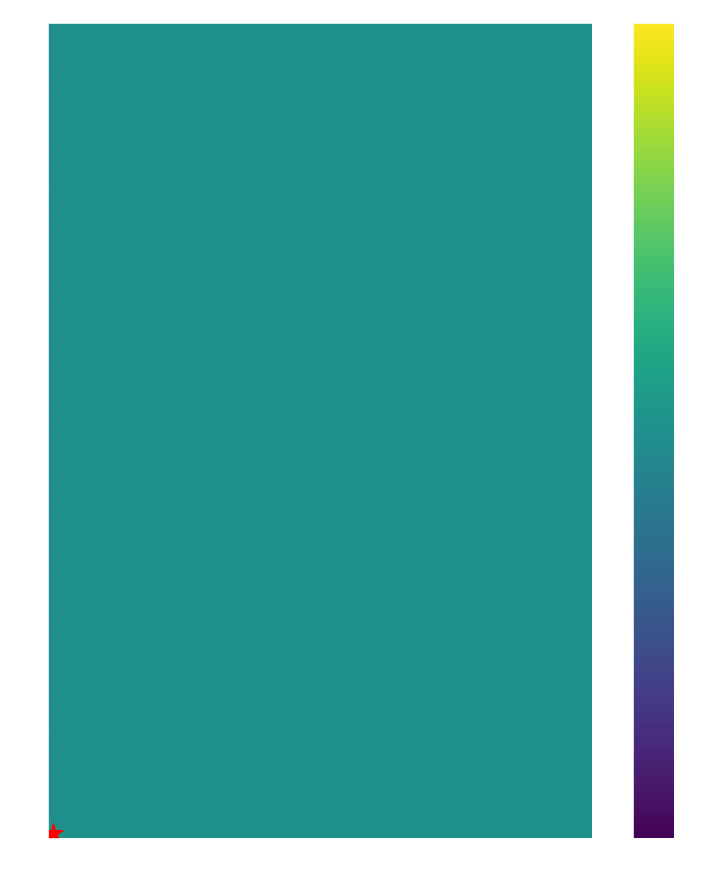

In [11]:

Nomega_m = 60
Nomega_L = 90
omega_ms = np.linspace(0.01,1,Nomega_m)
omega_Ls = np.linspace(0.01,1,Nomega_L)
X, Y = np.meshgrid(omega_ms,omega_Ls)

Zmax = 1000.
Z = np.ones((Nomega_L,Nomega_m))*Zmax

for i in np.arange(Nomega_m):
    for j in np.arange(Nomega_L):
        ms = redshift_pred(omega_ms[i],omega_Ls[j],redshift)
        chiv = (dist_mod-ms)/dist_mod_err
        chisq = np.sum(chiv[~indx]**2)
        Z[j,i] = min(chisq,Zmax)

chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
omega_m = X[am]
omega_L = Y[am]
omega_k = 1.-omega_m-omega_L

mc = redshift_pred(omega_m,omega_L,redshift_guess)  

b = []
for omega_m in omega_ms:
    for omega_L in omega_Ls:
        if (np.sum((omega_m*(1+redshift_guess)**3+(1.-omega_m-omega_L)*(1+redshift_guess)**2+omega_L) < 0.)):
            b.append((omega_m,omega_L))
            break
b = np.array(b)

# plot the chisq and contours
plt.figure(figsize = (15,15))
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap='viridis', extent=(0.,1.0,0.,1.5))
plt.colorbar()
plt.plot(X[am],Y[am],'r*',markersize=20)
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$\Omega_\Lambda$')
plt.title('Brute Force Reduced Chi-Square-Fit')
plt.show()